Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

# Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [2]:
display(visits)
print(visits.info())
display(orders)
print(orders.info())
display(costs)
print(costs.info())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
...,...,...,...,...,...,...
309896,329994900775,UK,PC,LeapBob,2019-10-31 13:28:12,2019-10-31 14:39:29
309897,334903592310,France,PC,lambdaMediaAds,2019-10-31 22:14:52,2019-10-31 22:39:36
309898,540102010126,Germany,PC,organic,2019-10-31 01:40:48,2019-10-31 01:41:31
309899,308736936846,Germany,Mac,organic,2019-10-31 07:37:34,2019-10-31 07:37:55


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


Заметно нарушение общего стиля написания кода, поэтому переименуем столбцы и приведем к нужному формату даты, добавив разбиение на месяцы в табличке costs

In [3]:
visits = visits.rename(columns={'User Id':'user_id', 'Region':'region', 'Device':'device', 'Channel':'channel',
                                'Session Start':'session_start', 'Session End':'session_end'})
orders = orders.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt', 'Revenue':'revenue'})
costs = costs.rename(columns={'Channel':'channel'})

In [4]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs['month'] = costs['dt'].astype('datetime64[M]')

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [6]:
orders.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [7]:
visits.value_counts('user_id')

user_id
33606575057     46
943775408561    36
901180916748    35
870784569391    34
86617872511     33
                ..
610429682603     1
236113143735     1
236126190518     1
610402853175     1
497707997464     1
Length: 150008, dtype: int64

In [8]:
visits.value_counts(['user_id','session_start'])

user_id       session_start      
599326        2019-05-07 20:58:57    1
666436527290  2019-10-23 21:07:52    1
666435389723  2019-07-19 15:48:19    1
              2019-07-15 20:29:18    1
666433868763  2019-10-05 00:09:54    1
                                    ..
332723282266  2019-10-14 19:12:17    1
              2019-10-13 16:48:25    1
332721581435  2019-06-15 16:38:01    1
332720746034  2019-09-21 04:44:04    1
999999563947  2019-10-20 04:10:34    1
Length: 309901, dtype: int64

In [9]:
visits.query('user_id==33606575057').head(5)

,user_id,region,device,channel,session_start,session_end
918,33606575057,United States,Android,RocketSuperAds,2019-05-02 17:29:40,2019-05-02 17:47:08
2114,33606575057,United States,Android,RocketSuperAds,2019-05-04 23:00:37,2019-05-04 23:08:15
4021,33606575057,United States,Android,RocketSuperAds,2019-05-06 05:09:27,2019-05-06 05:16:04
5040,33606575057,United States,Android,RocketSuperAds,2019-05-07 16:23:45,2019-05-07 16:37:15
5988,33606575057,United States,PC,organic,2019-05-08 00:48:57,2019-05-08 01:14:12


In [10]:
print(visits.duplicated().sum(),orders.duplicated().sum(),costs.duplicated().sum())

0 0 0


In [11]:
orders.drop_duplicates().reset_index(drop=True)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


Полных дубликатов не обнаружено, так же по столбцу user_id не найдено дубликатов, тк повторяющиеся user_id принадлежат разным сессиям

## Задание функций  для расчета и анализа LTV, ROI, удержания и конверсии

In [12]:
def get_profiles(sessions, orders, ad_costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [13]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [15]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [16]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [17]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


In [18]:
def plot_retention(retention, retention_history, horizon):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    ).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # исключаем наложение графиков друг на друга
    plt.tight_layout()

    plt.show()

In [19]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Профили пользователей. Минимальная и максимальная дата привлечения пользователей.

- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [20]:
window = 3
observation_date = datetime(2019, 10, 27).date()
min_date = datetime(2019,5,1).date()
horizon_analysis = 14

Задаем ширу окна для сглаживания значений равной 3. Определяем дату как начало и конец указанного периода и задаем горизонт анализа

In [21]:
profiles = get_profiles(visits, orders, costs)

In [22]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Таблица профилей получена, переходим к построению графиков разбиения пользователей на группы

,region,count,sum,mean
,,payer,payer,payer
0,France,17450,663,3.80
1,Germany,14981,616,4.11
2,UK,17575,700,3.98
3,United States,100002,6902,6.90


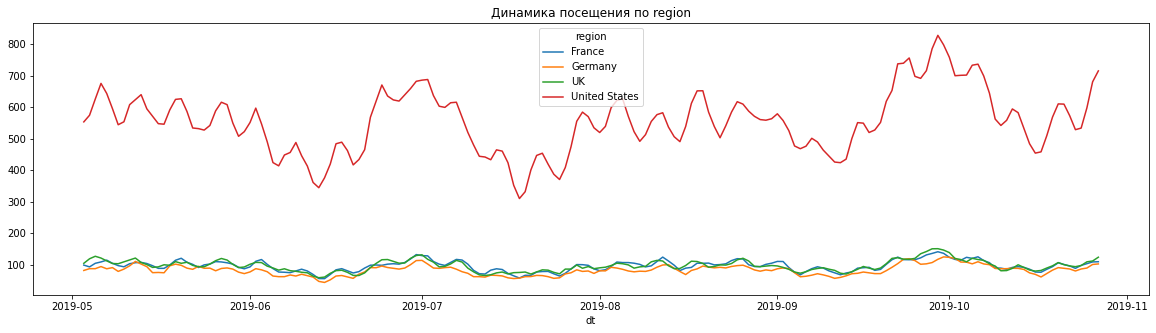

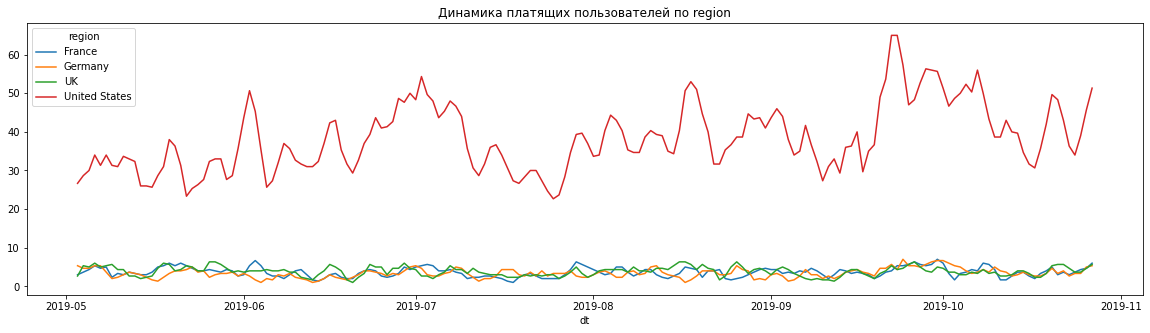

,device,count,sum,mean
,,payer,payer,payer
0,Android,35032,2050,5.85
1,Mac,30042,1912,6.36
2,PC,30455,1537,5.05
3,iPhone,54479,3382,6.21


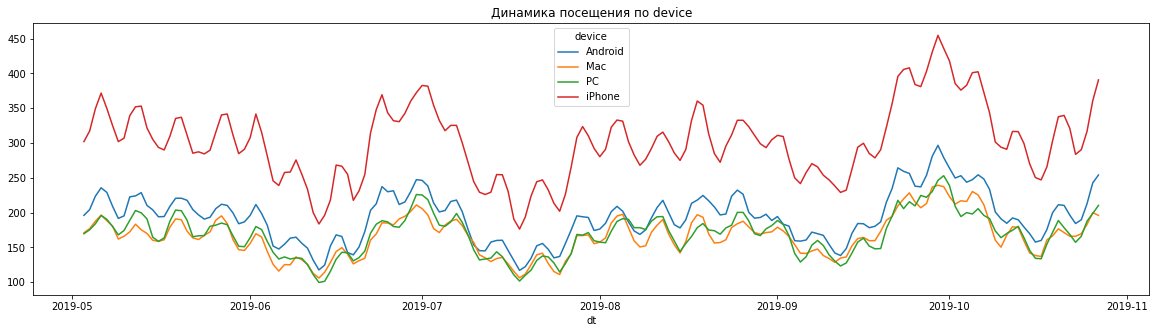

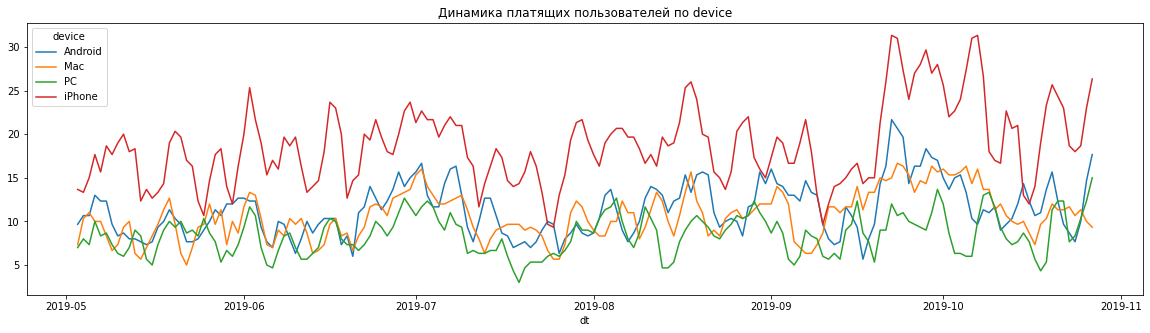

,channel,count,sum,mean
,,payer,payer,payer
0,AdNonSense,3880,440,11.34
1,FaceBoom,29144,3557,12.20
2,LeapBob,8553,262,3.06
3,MediaTornado,4364,156,3.57
4,OppleCreativeMedia,8605,233,2.71
5,RocketSuperAds,4448,352,7.91
6,TipTop,19561,1878,9.60
7,WahooNetBanner,8553,453,5.30
8,YRabbit,4312,165,3.83


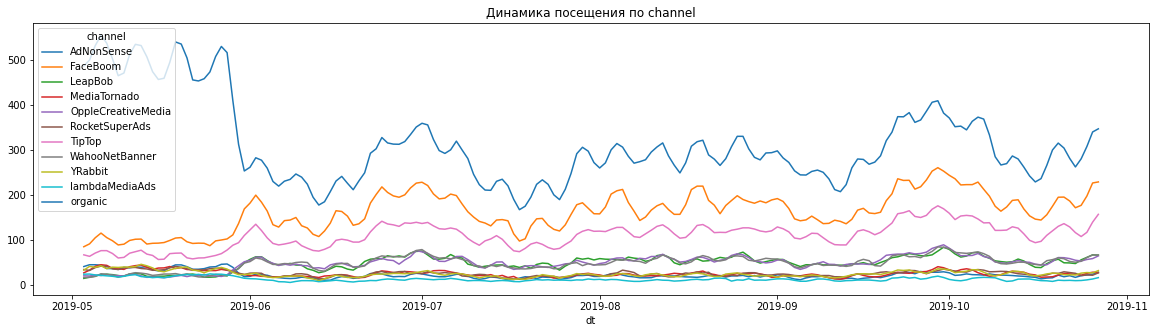

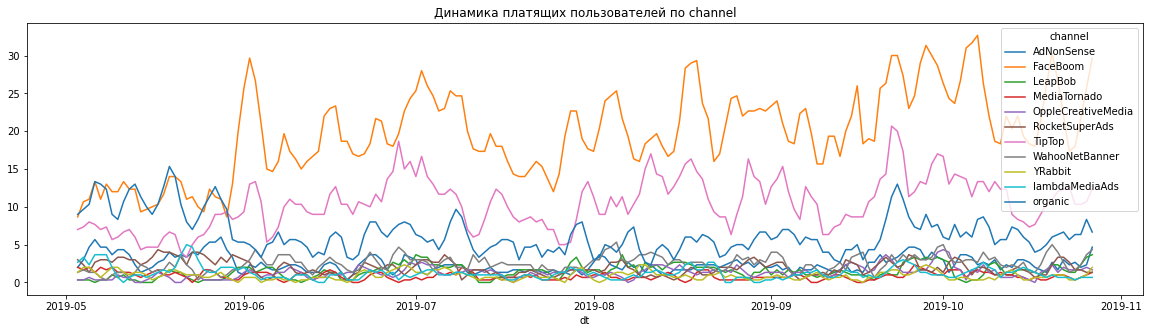

In [23]:
for sign in ['region','device','channel']:
    t=profiles.pivot_table(index=sign ,values='payer',aggfunc=['count','sum','mean']).reset_index()
    t['mean']=round(t['mean']*100,2)
    display(t)
    filter_data(profiles.pivot_table(index='dt',columns = sign, values='user_id',aggfunc='count'),window).plot(figsize=(20,5))
    plt.title('Динамика посещения по {}'.format(sign))
    filter_data(profiles.pivot_table(index='dt',columns = sign, values='payer',aggfunc='sum'),window).plot(figsize=(20,5))
    plt.title('Динамика платящих пользователей по {}'.format(sign))
    plt.show()
    print()

По графикам видно, что наибольшее количество посетителей и покупателей приходят из USA, в то время как все остальные страны имеют очень низкие показатели как по покупкам, так и по посещениям

Наибольшее количество посетителей и оплат наблюдаются с устройства Iphone.

Наибольший процент конвертированных пользователей у Faceboom, после него идет TipTop, но на 50% меньше пользователей конвертировалось, замыкает тройку самостоятельно нашедшие приложение. Остальные рекламные кампании показывают себя не с лучшей стороны.

## Вывод:
Приложение имеет популярность в USA, но большинство рекламных кампаний не дают стоящего результата, люди охотно находят приложение самостоятельно и этот показатель очень высок относительно большинства рекламных действий. Следует рассмотреть затраты на рекламные действия и сделать выводы по тому, что следовало бы поменять.

## Маркетинг

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

На рекламу потратили всего 105497
На рекламу в каждом источнике потратили


,costs
channel,
AdNonSense,3911.25
FaceBoom,32445.60
LeapBob,1797.60
MediaTornado,954.48
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
TipTop,54751.30
WahooNetBanner,5151.00
YRabbit,944.22


На рекламу по месяцам уходило


,costs
month,
2019-05-01,9978.570
2019-06-01,15090.045
2019-07-01,16447.060
2019-08-01,20657.870
2019-09-01,22441.340
2019-10-01,20882.415


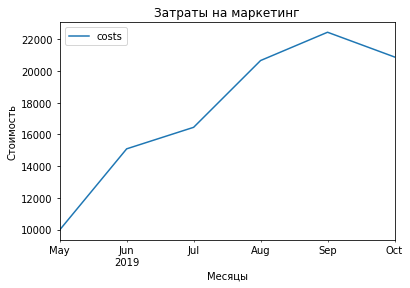

In [48]:
print('На рекламу потратили всего {}'.format(round(costs['costs'].sum())))
print('На рекламу в каждом источнике потратили')
display(costs.groupby('channel').agg({'costs':'sum'}))
print('На рекламу по месяцам уходило')
display(costs.groupby('month').agg({'costs':'sum'}))
costs.groupby('month').agg({'costs':'sum'}).plot()
plt.title('Затраты на маркетинг')
plt.xlabel('Месяцы')
plt.ylabel('Стоимость')
plt.show()

Наблюдается увеличение затрат на рекламные кампании со временем, но успешности этих кампаний не гарантированы и вероятнее всего будут низкими, исходя из данных об оплате пользователей

In [49]:
round(profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values('acquisition_cost',ascending=False),3)

,acquisition_cost
channel,
TipTop,2.799
FaceBoom,1.113
AdNonSense,1.008
lambdaMediaAds,0.725
WahooNetBanner,0.602
RocketSuperAds,0.412
OppleCreativeMedia,0.250
YRabbit,0.219
MediaTornado,0.219


In [42]:
print('Средний CAC на проект {}'.format(round(profiles['acquisition_cost'].mean(),3)))

Средний CAC на проект 0.703


## Выводы
Дорогое привлечение большого количества пользователей TipTop не оправдывает себя, потому что пользователи стоят в 2,5 раза дороже чем у FaceBoom, но количество платящих среди них заметно ниже чем у FaceBoom, да и количество пользователей от Faceboom больше. А что касается остальных рекламных действий, они отстают от пользователей самостоятельно зашедших в приложение и сделавших покупки. 
В среднем один рекламный клиент обходится компании в 70 центов(!? смотря в чем измеряем).
С течением времени в приложение стало заходить большее количество человек, но количество прибыли не выросло пропорционально затратам, а осталось почти на своем уровне.

## Оценка окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируем общую окупаемость рекламы

In [27]:
prof = profiles.query('channel!="organic"')

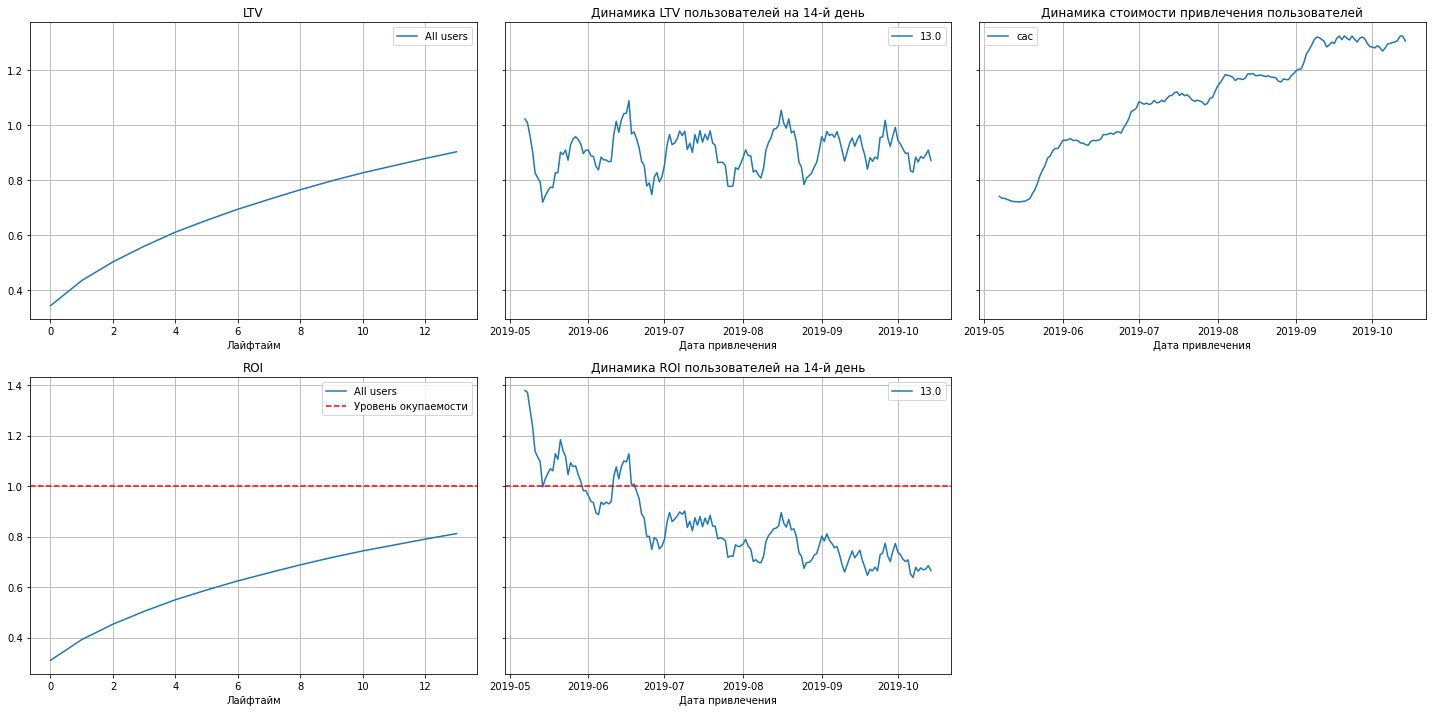

In [28]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(prof, orders, observation_date, horizon_analysis)
plot_ltv_roi(ltv,ltv_history,roi,roi_history,14,window=7)

### Проанализируем окупаемость рекламы с разбивкой по устройствам

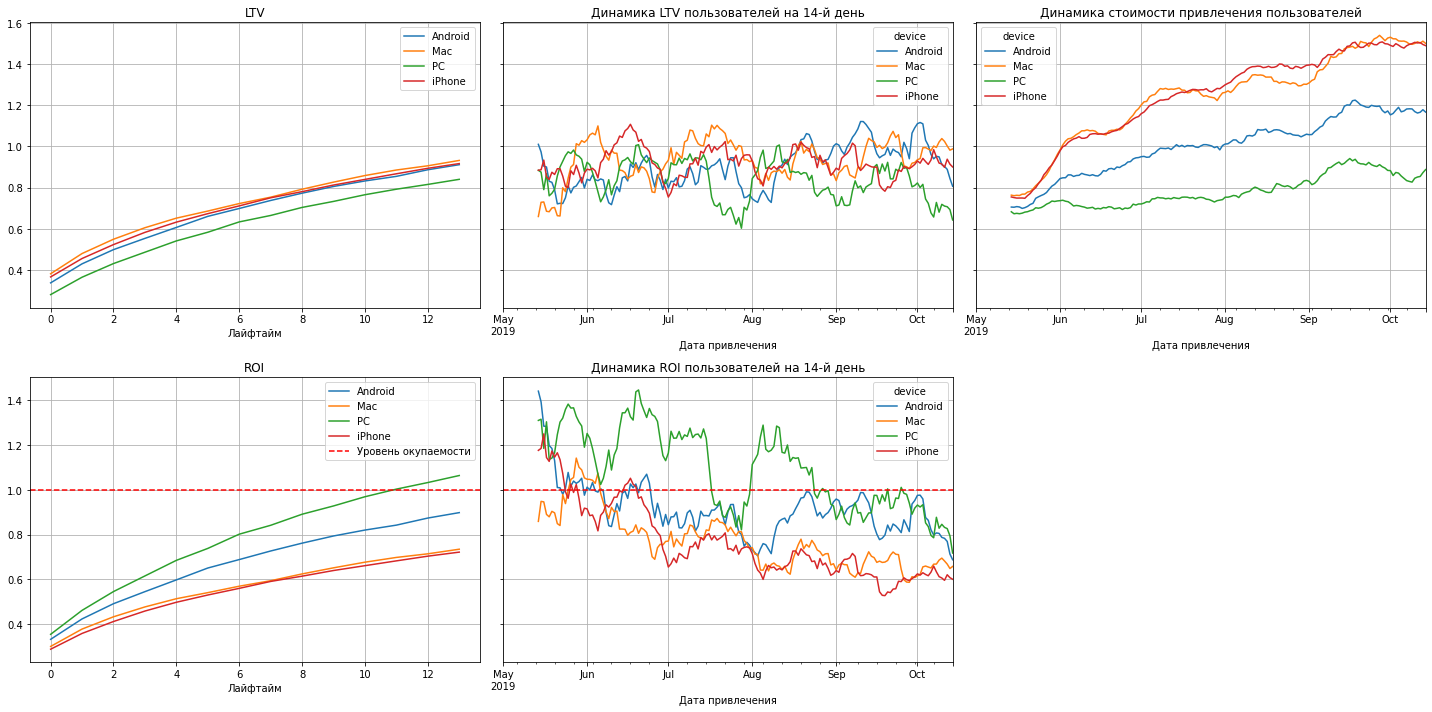

In [29]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(prof, orders, observation_date, horizon_analysis, dimensions=['device'])
plot_ltv_roi(ltv,ltv_history,roi,roi_history,14,window=14)

### Проанализируем окупаемость рекламы с разбивкой по странам

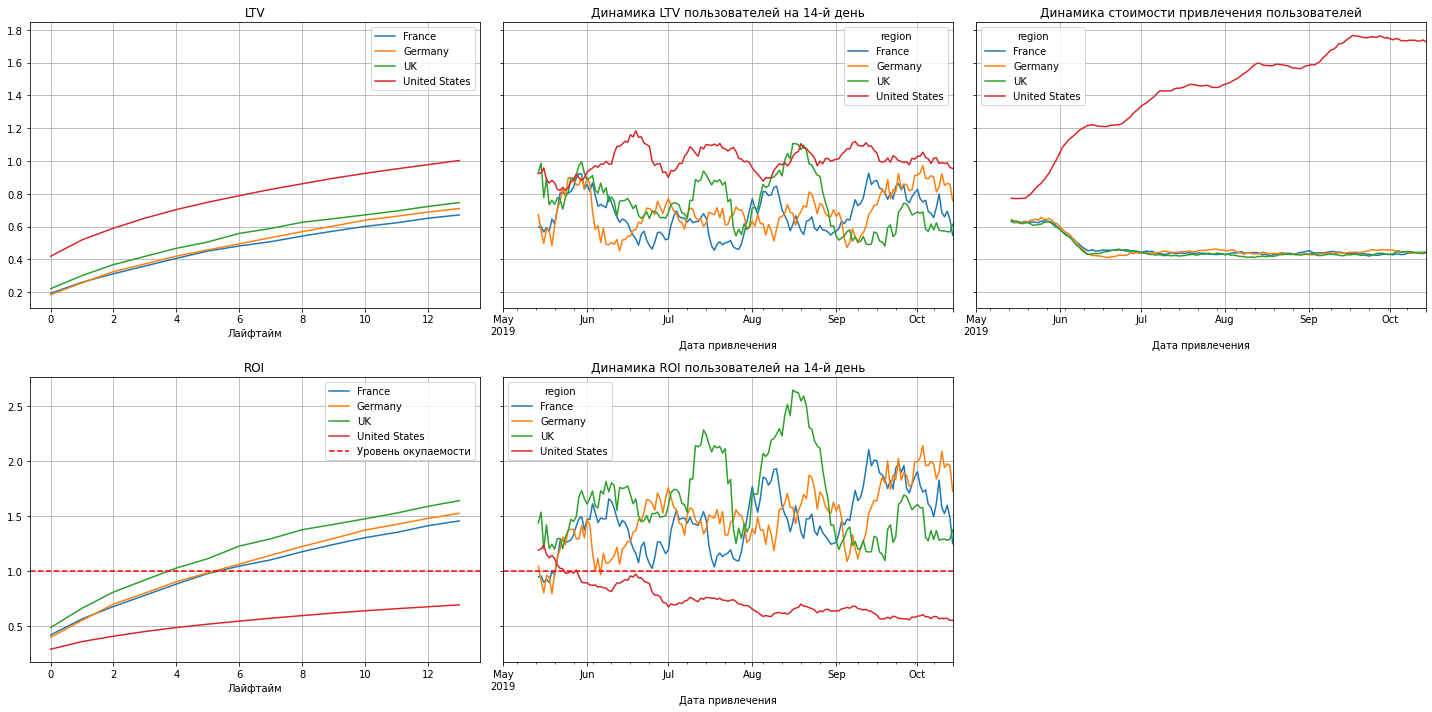

In [30]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(prof, orders, observation_date, horizon_analysis, dimensions=['region'])
plot_ltv_roi(ltv,ltv_history,roi,roi_history,14,window=14)

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

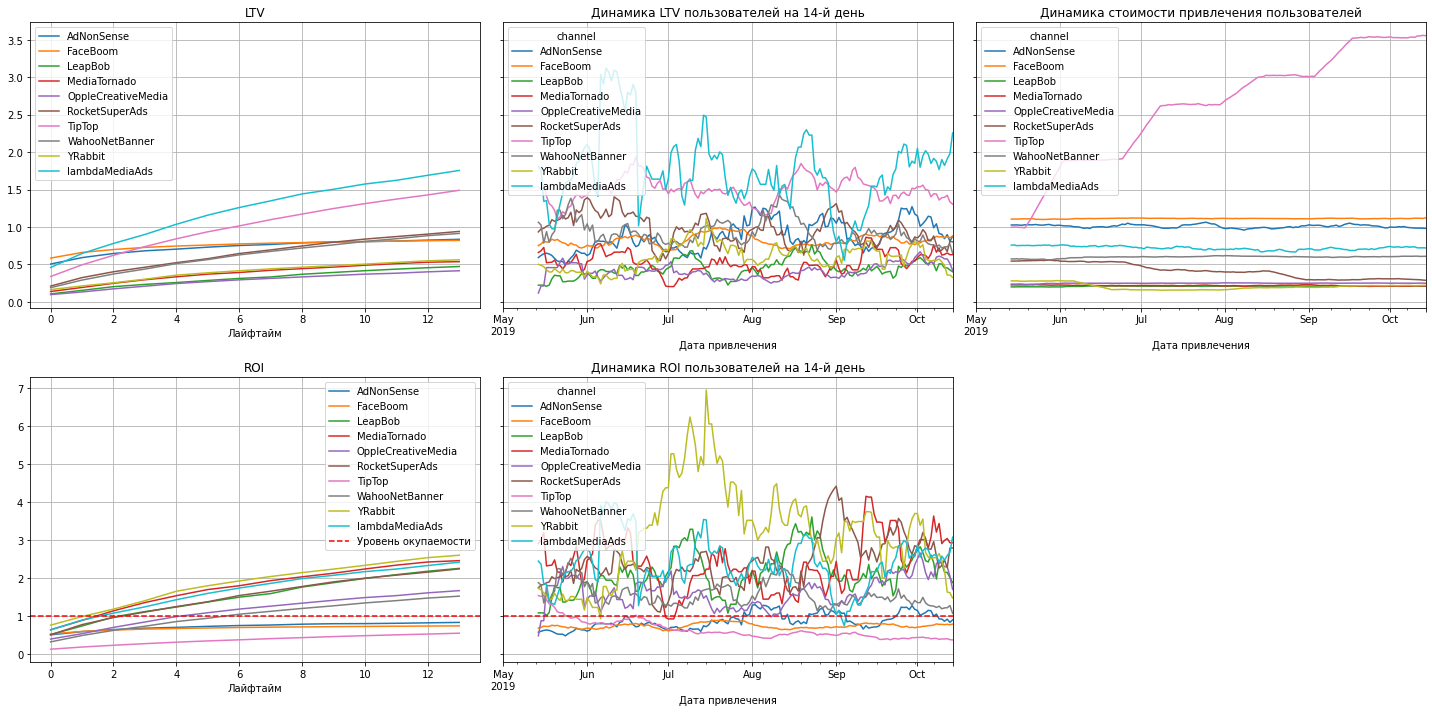

In [31]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(prof, orders, observation_date, horizon_analysis, dimensions=['channel'])
plot_ltv_roi(ltv,ltv_history,roi,roi_history,14,window=14)

## Вывод
Заметна проблема что поступает большой трафик пользователей из USA, но относительно своего количества они плохо конвертируются в платящих, в то время как у остальных регионов все идет стабильно около среднего без каких либо отклонений.

Заметно что кампания TipTop с каждым месяцем поднимает стоимость оплаты привлекаемых клиентов,а окупаемость этих клиентов самая низкая. Схожая картина и Faceboom, они так же не окупаются, но хотя бы стоимость рекламы неизменна.

Кампания YRabbit, хоть и маленькая, но наилучшая окупаемость, возможно с ними можно было бы договориться о большем объеме рекламы, тк их реклама окупается уже на второй день.

### Проанализируем конверсию и удержание

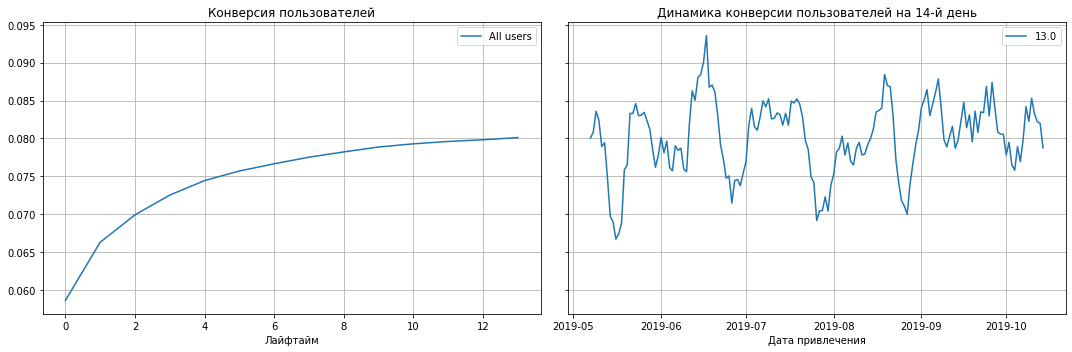

In [32]:
conversion_raw, conversion, conversion_history = get_conversion(prof, orders, observation_date, horizon_analysis)
plot_conversion(conversion, conversion_history,horizon_analysis)

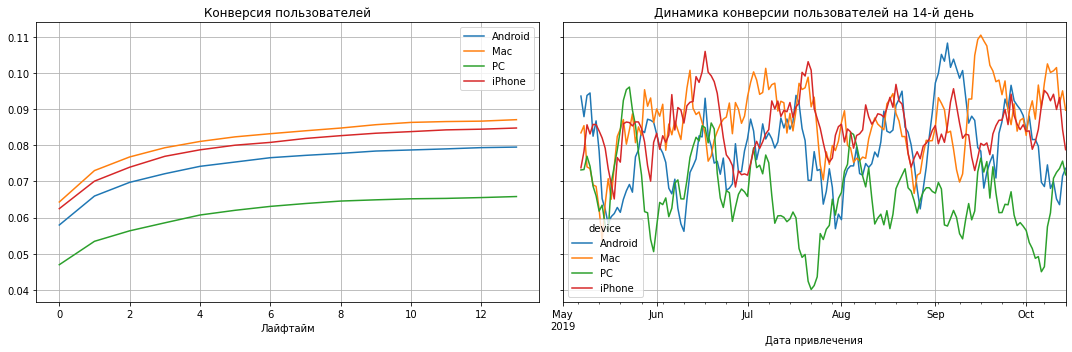

In [33]:
conversion_raw, conversion, conversion_history = get_conversion(prof, orders, observation_date, horizon_analysis, dimensions=['device'])
plot_conversion(conversion, conversion_history,horizon_analysis)

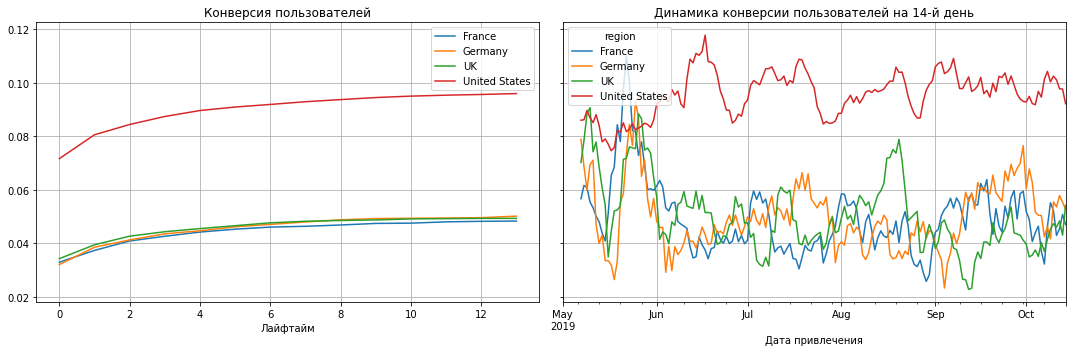

In [34]:
conversion_raw, conversion, conversion_history = get_conversion(prof, orders, observation_date, horizon_analysis, dimensions=['region'])
plot_conversion(conversion, conversion_history,horizon_analysis)

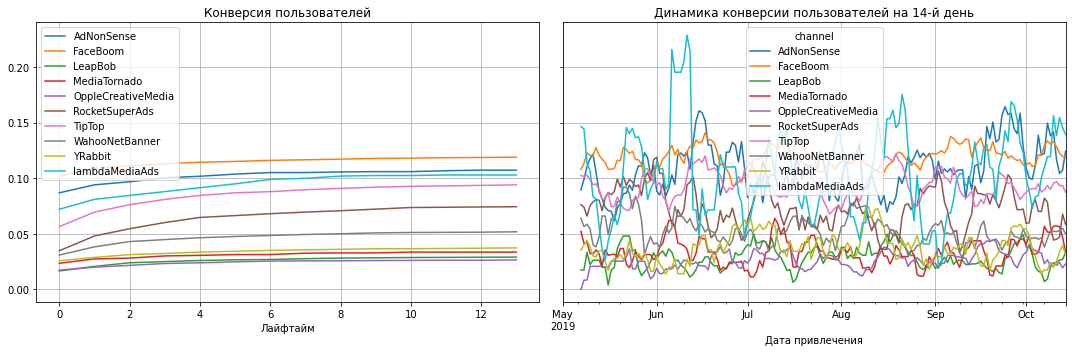

In [35]:
conversion_raw, conversion, conversion_history = get_conversion(prof, orders, observation_date, horizon_analysis, dimensions=['channel'])
plot_conversion(conversion, conversion_history,horizon_analysis)

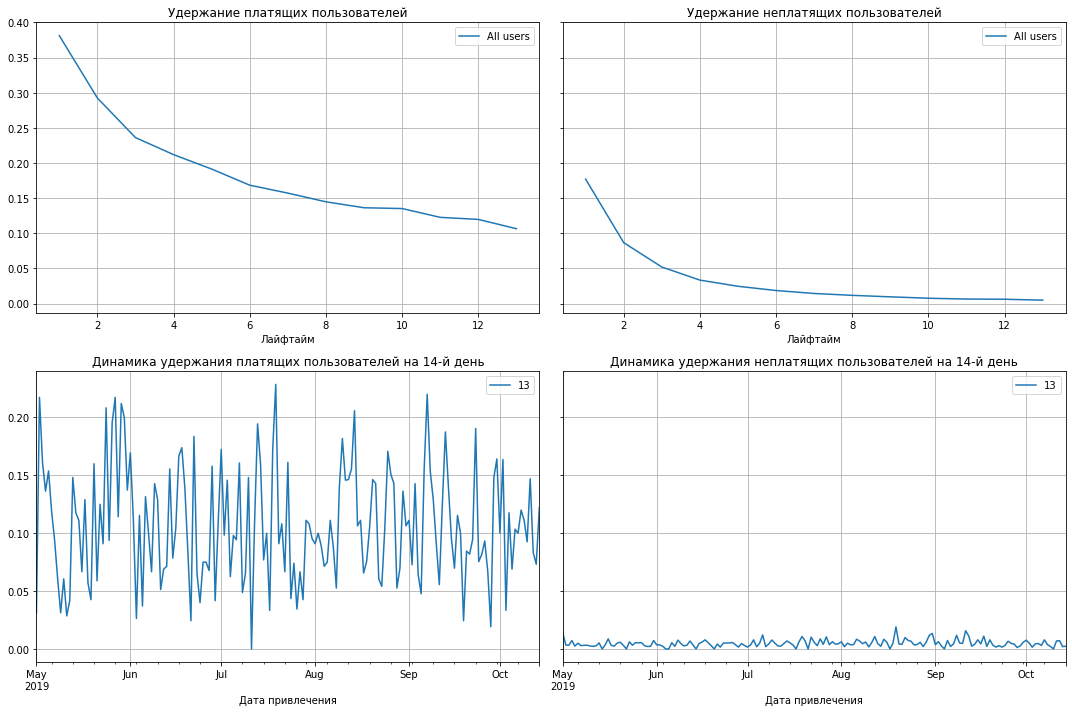

In [36]:
retention_raw, retention_grouped, retention_history = get_retention(
    prof, visits, observation_date, horizon_analysis)
plot_retention(retention_grouped, retention_history, horizon_analysis) 

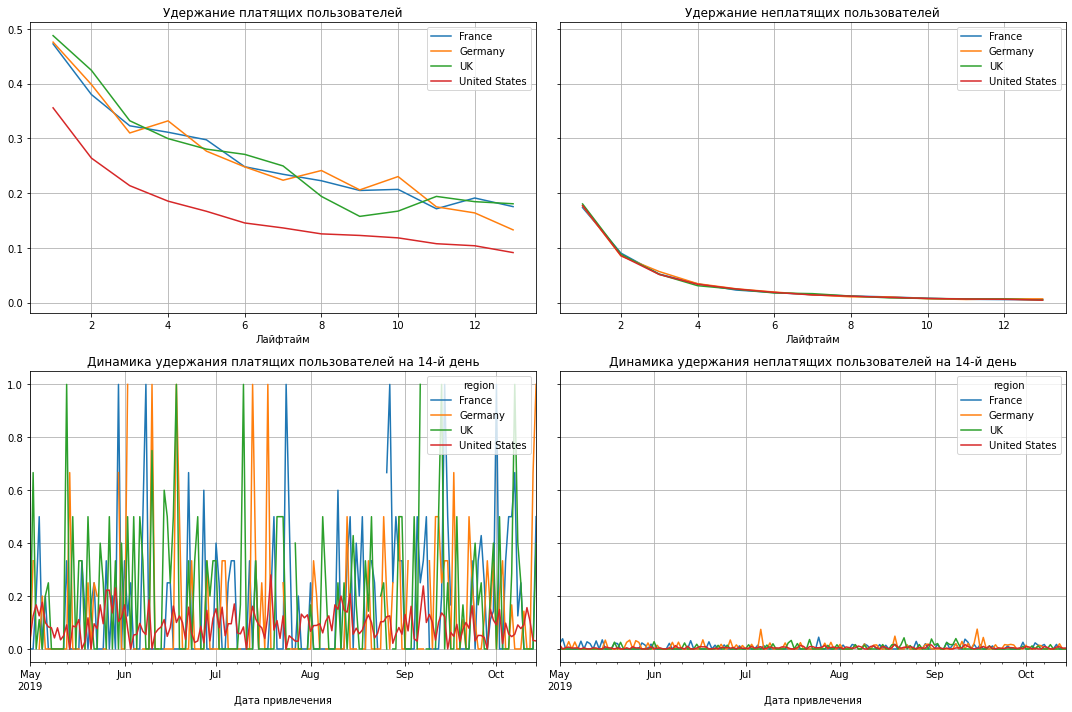

In [37]:
retention_raw, retention_grouped, retention_history = get_retention(
    prof, visits, observation_date, horizon_analysis, dimensions=['region'])
plot_retention(retention_grouped, retention_history, horizon_analysis) 

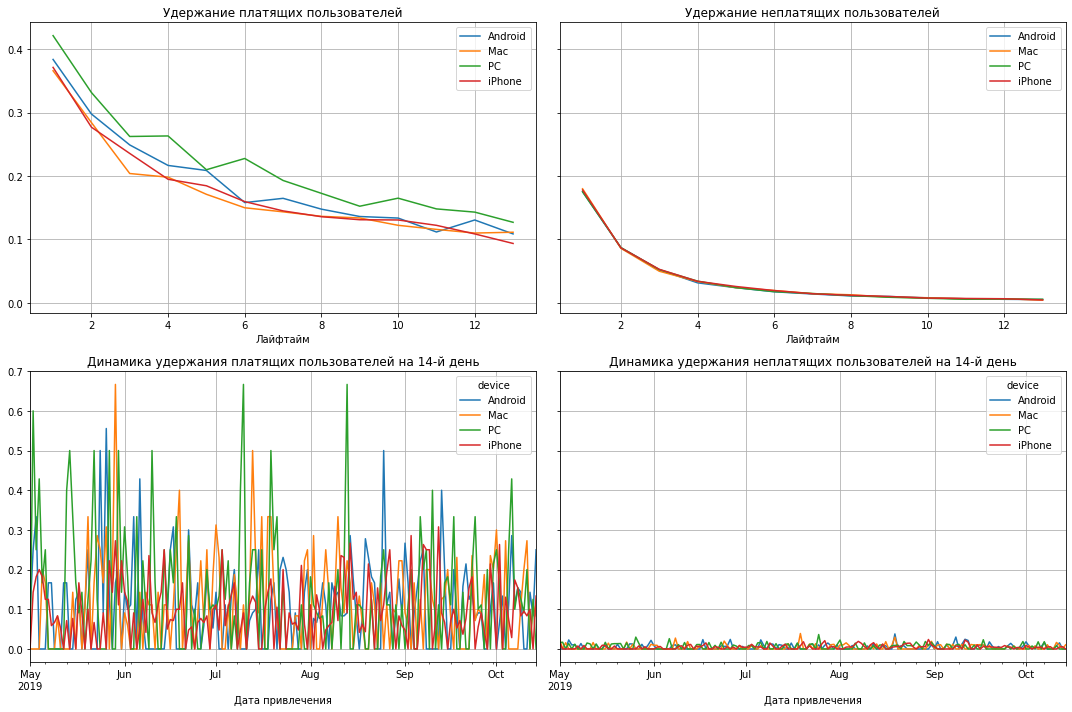

In [38]:
retention_raw, retention_grouped, retention_history = get_retention(
    prof, visits, observation_date, horizon_analysis,dimensions=['device'])
plot_retention(retention_grouped, retention_history, horizon_analysis) 

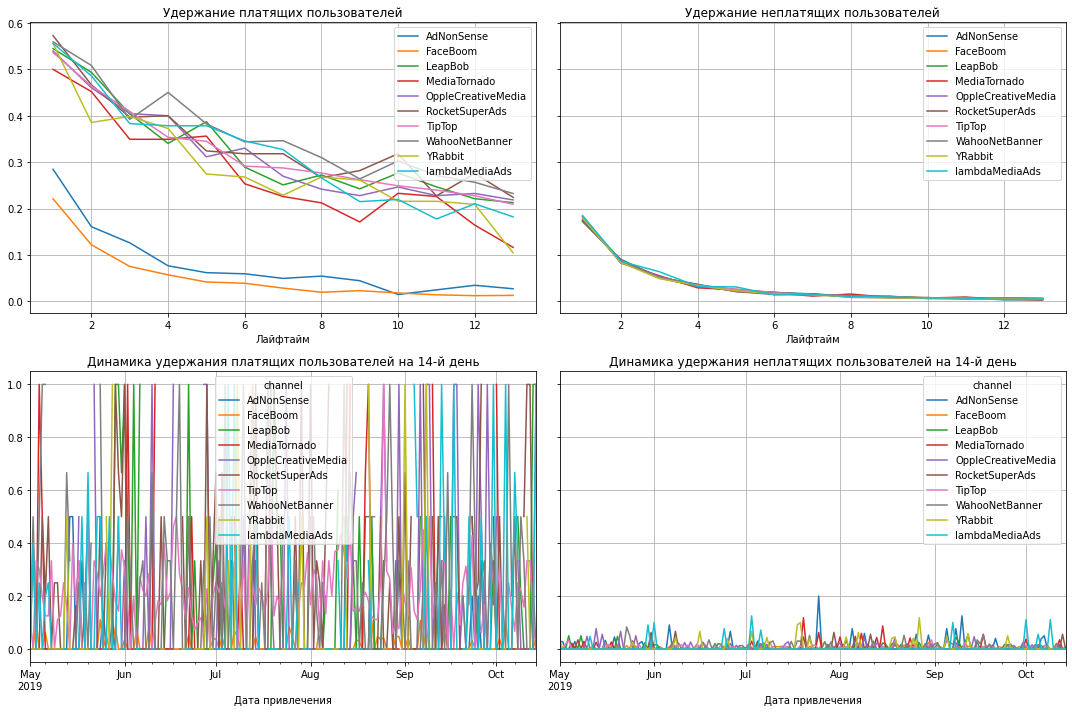

In [39]:
retention_raw, retention_grouped, retention_history = get_retention(
    prof, visits, observation_date, horizon_analysis, dimensions=['channel'])
plot_retention(retention_grouped, retention_history, horizon_analysis) 

Так же заметна подтверждается на удержании гипотеза о слабой конвертации и плохом удержании пользователей из USA, но и появилось плохое удержание отличное от всех у FaceBoom и AdNonSense

Проблема наблюдается в удержании USA пользователей и возникать они могут из-за сбоев, либо же каких-то других технических проблем, может оплата картой плохо работает. Требуется посмотреть по логам.

Окупаемость проекта пока что низкая, но уровень окупаемости почти достигнут, вероятнее всего требуется пересмотреть вложение средств в рекламные кампании, которые были бы выгоднее чем TipTop и Faceboom, хотя у последней хорошие показатели, кроме удержания.

Реклама в целом себя не окупает

# Общий вывод

Данные были приведены к единому виду и стилю, добавлены требующиеся столбцы. Написаны функции для рассчетов. Произведен анализ графиков и таблиц. Написаны выводы по каждому разделу. Была найдена проблема с регионам посетителей приложения, которую потребуется решить.

Требуется произвести перераспределение рекламного бюджета и вероятнее всего стоило бы сосредоточиться на диверсификации затрат по регионам, тк пользователи привлекаемые из USA, конечно конвертируются лучше всего, но они и стоят в разы дороже.

Что касается плохого удержания пользователей привлеченных Faceboom  и AdNonSense, потребуется проверить из-за чего происходит сильный отток, тк у них лучший показатель конверсии.